In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
tf.random.set_seed(10000)

In [2]:
data_ex = os.listdir('Species/Converted_Images/Anthias anthias')
print(data_ex)

['anthias_anthias-0.jpg', 'anthias_anthias-1.jpg', 'anthias_anthias-10.jpg', 'anthias_anthias-100.jpg', 'anthias_anthias-1000.jpg', 'anthias_anthias-1001.jpg', 'anthias_anthias-1002.jpg', 'anthias_anthias-1003.jpg', 'anthias_anthias-1004.jpg', 'anthias_anthias-1005.jpg', 'anthias_anthias-1006.jpg', 'anthias_anthias-1007.jpg', 'anthias_anthias-1008.jpg', 'anthias_anthias-1009.jpg', 'anthias_anthias-101.jpg', 'anthias_anthias-1010.jpg', 'anthias_anthias-1011.jpg', 'anthias_anthias-1012.jpg', 'anthias_anthias-1013.jpg', 'anthias_anthias-1014.jpg', 'anthias_anthias-1015.jpg', 'anthias_anthias-1016.jpg', 'anthias_anthias-1017.jpg', 'anthias_anthias-1018.jpg', 'anthias_anthias-1019.jpg', 'anthias_anthias-102.jpg', 'anthias_anthias-1020.jpg', 'anthias_anthias-1021.jpg', 'anthias_anthias-1022.jpg', 'anthias_anthias-1023.jpg', 'anthias_anthias-1024.jpg', 'anthias_anthias-1025.jpg', 'anthias_anthias-1026.jpg', 'anthias_anthias-1027.jpg', 'anthias_anthias-1028.jpg', 'anthias_anthias-1029.jpg', 'a

In [3]:
train_dir = os.listdir('Species/Converted_Images/')
test_dir = os.listdir('Species/Test_Set/')

In [4]:
len(train_dir)

20

In [5]:
len(test_dir)

20

In [6]:
targetnames = train_dir
print(targetnames)

['Anthias anthias', 'Atherinomorus lacunosus', 'Belone belone', 'Boops boops', 'Chlorophthalmus agassizi', 'Coris julis', 'Dasyatis centroura', 'Epinephelus caninus', 'Gobius niger', 'Mugil cephalus', 'Phycis phycis', 'Polyprion americanus', 'Pseudocaranx dentex', 'Rhinobatos cemiculus', 'Scomber japonicus', 'Solea solea', 'Squalus acanthias', 'Tetrapturus belone', 'Trachinus draco', 'Trigloporus lastoviza']


In [7]:
def toRgba(image):
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)+
    image_rgb = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    image_rgb = np.array(image_rgb,dtype=np.float32)
    return image_rgb

In [ ]:
# Augmenting images and storing them in temporary directories 
for img_class in targetnames:

    #creating temporary directories
    # creating a base directory
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_list = os.listdir('Species/Converted_Images/' + img_class)

    # Copy images from the class train dir to the img_dir 
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join('Species/Converted_Images/' + img_class, file_name)

        # creating a target directory to send images 
        target = os.path.join(img_dir, file_name)
        
        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = aug_dir

    # Augmented images will be saved to training directory
    save_path = 'Species/Converted_Images/' + img_class

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        preprocessing_function=toRgba,
        fill_mode='nearest'
    )
    
    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,
                                              save_to_dir=save_path,save_format='jpg',
                                              target_size=(224, 224),
                                              batch_size=batch_size
                                             )

    # Generate the augmented images
    aug_images = 8000 

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)
    # delete temporary directory 
    shutil.rmtree('aug_dir')

In [7]:
train_path = 'Species/Training_Set/'
test_path = 'Species/Test_Set/'
batch_size=16

In [8]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [9]:
image_size = 299
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 34000 images belonging to 20 classes.

Test Batches: 
Found 6000 images belonging to 20 classes.


In [10]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

input_shape = (299, 299, 3)

num_labels = 5

base_model = InceptionV3(include_top=False, input_shape=(299, 299, 3),pooling = 'avg')
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(20, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = True

#for layer in base_model.layers[-30:]:
 #   layer.trainable = True

#model.add(ResNet50(include_top = False, pooling = 'max', weights = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
Total params: 22,067,636
Trainable params: 22,033,204
Non-trainable params: 34,432
_________________________________________________________________


In [11]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [12]:
class_weights = {   
                    0: 1.0,  # Anthias anthias
                    1: 1.0,  # Atherinomorus Laconusus
                    2: 1.0,  # Belone belone
                    3: 1.0,  # Boops boops
                    4: 1.0,  # Chlorophthalmus agassizi
                    5: 1.0,  # Coris julis
                    6: 1.0,  # Dasyatis centroura
                    7: 1.0,  # Epinephelus caninus
                    8: 1.0,  # Gobius niger
                    9: 1.0,  # Mugil cephalus
                    10: 1.0,  # Phycis phycis
                    11: 1.0,  # Polyprion americanus
                    12: 1.0,  # Pseudocaranx dentex
                    13: 1.0,  # Rhinobatos cemiculus
                    14: 1.0,  # Scomber japonicus
                    15: 1.0,  # Solea solea
                    16: 1.0,  # Squalus acanthias
                    17: 1.0,  # Tetrapturus belone
                    18: 1.0,  # Trachinus draco
                    19: 1.0,  # Trigloporus lastoviza
                }


In [13]:
checkpoint=  ModelCheckpoint(filepath = 'InceptionV3-AdamNonAugmented.hdf5',monitor='accuracy',save_best_only=True,save_weights_only=True)

In [14]:
Earlystop = EarlyStopping(monitor='accuracy', mode='min',patience=65, min_delta=0.001)
history = model.fit(train_batches,
                    steps_per_epoch=len(test_batches),
                    epochs=100,
                    verbose=1,
#                     validation_data=test_batches,
#                     validation_steps=len(test_batches)/batch_size,
                    callbacks=[checkpoint,Earlystop],
                    class_weight=class_weights)
print("Training Done")

Epoch 1/100
375/375 [==============================] - 135s 322ms/step - loss: 5.3907 - accuracy: 0.5282
Epoch 2/100
375/375 [==============================] - 122s 324ms/step - loss: 1.9351 - accuracy: 0.7898
Epoch 3/100
375/375 [==============================] - 122s 325ms/step - loss: 1.1244 - accuracy: 0.8508
Epoch 4/100
375/375 [==============================] - 122s 325ms/step - loss: 1.0003 - accuracy: 0.8608
Epoch 5/100
375/375 [==============================] - 122s 326ms/step - loss: 0.8899 - accuracy: 0.8867
Epoch 6/100
375/375 [==============================] - 122s 326ms/step - loss: 0.8510 - accuracy: 0.8993
Epoch 7/100
375/375 [==============================] - 122s 325ms/step - loss: 0.8175 - accuracy: 0.9058
Epoch 8/100
375/375 [==============================] - 122s 325ms/step - loss: 0.7340 - accuracy: 0.9273
Epoch 9/100
375/375 [==============================] - 122s 325ms/step - loss: 0.7175 - accuracy: 0.9272
Epoch 10/100
375/375 [==============================] -

In [15]:
from tensorflow.keras import models
model.load_weights("InceptionV3-AdamNonAugmented.hdf5")

In [16]:
predictions = model.predict(test_batches, steps=6000/batch_size, verbose=1) #6000 adalah jumlah dataset untuk test

375/375 [==============================] - 54s 141ms/step


In [17]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_pred, y_true, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
                          precision    recall  f1-score   support

         Anthias anthias       1.00      1.00      1.00       300
 Atherinomorus lacunosus       1.00      1.00      1.00       301
           Belone belone       1.00      1.00      1.00       300
             Boops boops       1.00      1.00      1.00       299
Chlorophthalmus agassizi       1.00      1.00      1.00       300
             Coris julis       1.00      1.00      1.00       300
      Dasyatis centroura       1.00      1.00      1.00       300
     Epinephelus caninus       0.98      1.00      0.99       295
            Gobius niger       1.00      0.99      1.00       302
          Mugil cephalus       1.00      1.00      1.00       299
           Phycis phycis       1.00      1.00      1.00       300
    Polyprion americanus       1.00      0.98      0.99       305
     Pseudocaranx dentex       1.00      1.00      1.00       300
    Rhinobatos cemiculus       1.00      0.99      

In [18]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.9980180835471286
Recall: 0.998
Accuracy: 0.998
weighted Roc score: 0.9999966666666668


In [19]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.9980180835471287
Recall: 0.9979999999999999
Accuracy: 0.998
Macro Roc score: 0.9999966666666668


In [20]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.998
Recall: 0.998
Accuracy: 0.998
Micro Roc score: 0.9999904868421052


In [21]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(20):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of Anthias anthias is: 1.0
The ROC AUC score of Atherinomorus lacunosus is: 0.9999994152046784
The ROC AUC score of Belone belone is: 1.0
The ROC AUC score of Boops boops is: 0.9999959064327485
The ROC AUC score of Chlorophthalmus agassizi is: 1.0
The ROC AUC score of Coris julis is: 0.9999999999999999
The ROC AUC score of Dasyatis centroura is: 0.9999994152046784
The ROC AUC score of Epinephelus caninus is: 0.9999643274853801
The ROC AUC score of Gobius niger is: 1.0
The ROC AUC score of Mugil cephalus is: 0.9999994152046783
The ROC AUC score of Phycis phycis is: 1.0
The ROC AUC score of Polyprion americanus is: 0.9999836257309942
The ROC AUC score of Pseudocaranx dentex is: 1.0
The ROC AUC score of Rhinobatos cemiculus is: 0.9999976608187136
The ROC AUC score of Scomber japonicus is: 1.0
The ROC AUC score of Solea solea is: 0.9999999999999999
The ROC AUC score of Squalus acanthias is: 0.9999935672514619
The ROC AUC score of Tetrapturus belone is: 1.0
The ROC AUC sco

In [22]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(20):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

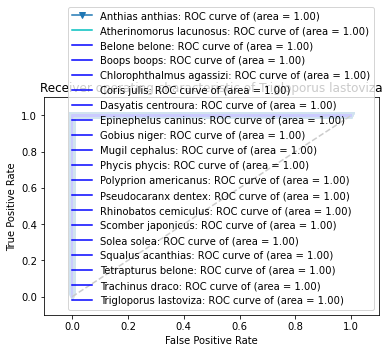

In [23]:
plt.plot(fpr[0], tpr[0],'v-',label='Anthias anthias: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='Atherinomorus lacunosus: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='Belone belone: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'b',label='Boops boops: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'b',label='Chlorophthalmus agassizi: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'b',label='Coris julis: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'b',label='Dasyatis centroura: ROC curve of (area = %0.2f)' % roc_auc[6])
plt.plot(fpr[7], tpr[7],'b',label='Epinephelus caninus: ROC curve of (area = %0.2f)' % roc_auc[7])
plt.plot(fpr[8], tpr[8],'b',label='Gobius niger: ROC curve of (area = %0.2f)' % roc_auc[8])
plt.plot(fpr[9], tpr[9],'b',label='Mugil cephalus: ROC curve of (area = %0.2f)' % roc_auc[9])
plt.plot(fpr[10], tpr[10],'b',label='Phycis phycis: ROC curve of (area = %0.2f)' % roc_auc[10])
plt.plot(fpr[11], tpr[11],'b',label='Polyprion americanus: ROC curve of (area = %0.2f)' % roc_auc[11])
plt.plot(fpr[12], tpr[12],'b',label='Pseudocaranx dentex: ROC curve of (area = %0.2f)' % roc_auc[12])
plt.plot(fpr[13], tpr[13],'b',label='Rhinobatos cemiculus: ROC curve of (area = %0.2f)' % roc_auc[13])
plt.plot(fpr[14], tpr[14],'b',label='Scomber japonicus: ROC curve of (area = %0.2f)' % roc_auc[14])
plt.plot(fpr[15], tpr[15],'b',label='Solea solea: ROC curve of (area = %0.2f)' % roc_auc[15])
plt.plot(fpr[16], tpr[16],'b',label='Squalus acanthias: ROC curve of (area = %0.2f)' % roc_auc[16])
plt.plot(fpr[17], tpr[17],'b',label='Tetrapturus belone: ROC curve of (area = %0.2f)' % roc_auc[17])
plt.plot(fpr[18], tpr[18],'b',label='Trachinus draco: ROC curve of (area = %0.2f)' % roc_auc[18])
plt.plot(fpr[19], tpr[19],'b',label='Trigloporus lastoviza: ROC curve of (area = %0.2f)' % roc_auc[19])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()

In [24]:
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
import numpy as np

label =  targetnames


def plot_confusion_matrix(y_true, y_pred, classes, normalize=True,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    cm2 = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
    cm2 = cm2 * 100
    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm2, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm2.shape[1]),
           yticks=np.arange(cm2.shape[0]),
           xticklabels=label, yticklabels=label,
           title=title,
           ylabel='Predicted label',
           xlabel='True label')

    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            z = cm[i, j]
            z = np.around(z)

            ax.text(j, i, format(z),
                    ha="center", va="center",
                    color="white" if i == j else "black")
    fig.tight_layout()
    return ax

#label nya ganti angka saja buat pengertian

[[300   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   1   0 299   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0 300   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0 299   0   0   0   0   0   0   0   0   1   0   0
    0   0]
 [  0   0   0   0   0   0   0 295   0   0   0   5   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0 300   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   1 299   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0 300   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 300   0   0   0   0

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='True label', ylabel='Predicted label'>

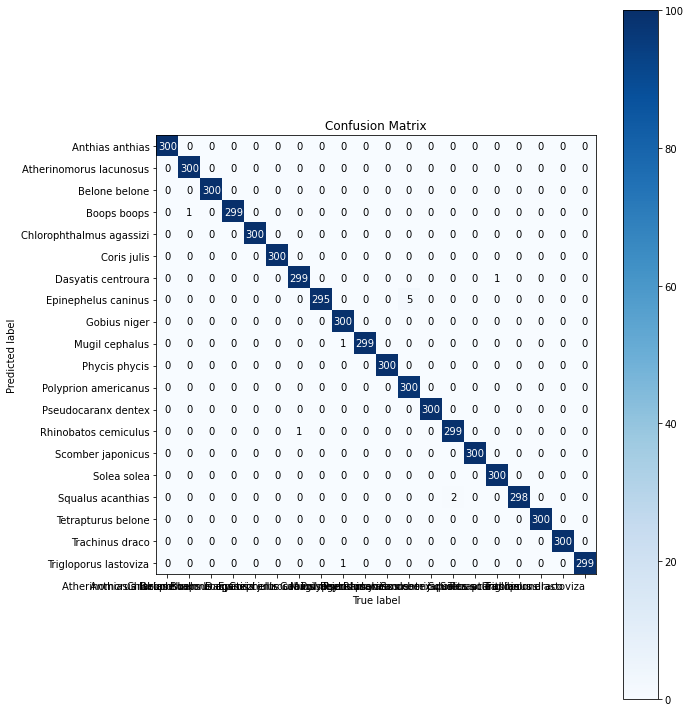

In [25]:
plot_confusion_matrix(y_true,y_pred,label)